In [1]:
try:
    import sys, os
    import time
    import datetime as dt
    import pandas as pd
    import numpy as np
    import boto3
    import s3fs
    from loadmodel import LoadModel
    import cvxpy as cvx
    import pickle
    import sklearn
    from sklearn.preprocessing import normalize
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import Ridge
except Exception as err:
    print("EXCEPTION",err,file=sys.stderr)
    import pip
    pip.main(["install","pip","--upgrade","-r","../requirements.txt"])
    print("ERROR: pip has changed your python environment, you need to run this cell again")

In [2]:
s3 = boto3.resource('s3')

# 1. Prepare data

~~Based on data_pipeline.py~~
Should ge generated using GMMs

In [3]:
gmm_bucket = 'script.control.tool'
s3client = boto3.client('s3')
gmm_folder_path = 'Sessions_Model_Objects/'
gmm_sub_path = 'sessions2019_work_slow_weekday_allbatt_se_5_gmm.p'
start_time_scaler = (1/(60*15))

In [4]:
def end_times_and_load(start_times, energies, rate, time_steps_per_hour=4, num_time_steps=96):

    num = np.shape(start_times)[0]
#     load = np.zeros((num_time_steps,))
    uncontrolled_load = np.zeros((num, num_time_steps))
    end_times = np.zeros(np.shape(start_times)).astype(int)

    lengths = (time_steps_per_hour * energies / rate).astype(int)
    extra_charges = energies - lengths * rate / time_steps_per_hour
    inds1 = np.where((start_times + lengths) > num_time_steps)[0]
    inds2 = np.delete(np.arange(0, np.shape(end_times)[0]), inds1)

    end_times[inds1] = (np.minimum(start_times[inds1].astype(int)+lengths[inds1]-num_time_steps, num_time_steps)).astype(int)
    end_times[inds2] = (start_times[inds2] + lengths[inds2]).astype(int)
    inds3 = np.where(end_times >= num_time_steps)[0]
    inds4 = np.delete(np.arange(0, np.shape(end_times)[0]), inds3)

    for i in range(len(inds1)):
        idx = int(inds1[i])
        uncontrolled_load[idx, np.arange(int(start_times[idx]), num_time_steps)] += rate * np.ones((num_time_steps - int(start_times[idx]),))
        uncontrolled_load[idx, np.arange(0, end_times[idx])] += rate * np.ones((end_times[idx],))
    for i in range(len(inds2)):
        idx = int(inds2[i])
        uncontrolled_load[idx, np.arange(int(start_times[idx]), end_times[idx])] += rate * np.ones((lengths[idx],))
    uncontrolled_load[inds3, 0] += np.sum(extra_charges[inds3] * time_steps_per_hour)
    uncontrolled_load[inds4, end_times[inds4]] += extra_charges[inds4] * time_steps_per_hour

    load = np.sum(uncontrolled_load, axis=0)
    return end_times, load, uncontrolled_load


In [5]:
def load_data(num_vehicles):
    key = gmm_folder_path + gmm_sub_path
    response = s3client.get_object(Bucket=gmm_bucket, Key=key)
    joint_gmm = pickle.loads(response['Body'].read())

    sample_output = joint_gmm.sample(num_vehicles)[0]
    sample_output = sample_output[np.random.choice(np.shape(sample_output)[0], np.shape(sample_output)[0], replace=False), :]
    start_times = (start_time_scaler * np.mod(sample_output[:, 0], 24 * 3600)).astype(int)
    energies = np.abs(sample_output[:, 1])
    energies = np.clip(energies, 0, 75)
    
    end_times, load, uncontrolled_load = end_times_and_load(start_times, energies, 6.6)
    end_times = np.ceil(np.mod(end_times, 96))#start_times + start_time_scaler*sample_output[:, 2], 96))
    
    return uncontrolled_load, start_times, end_times

### define rate schedule

In [6]:
### pge e19 example:

# demand_charges = [(21.23, np.arange(int(12 * 4), int(18 * 4))), (19.10, np.arange(0, int(24 * 4))), (5.85, np.concatenate((np.arange(int(8.5 * 4), int(12 * 4)), np.arange(int(18 * 4), int(21.5 * 4)))))]
# energy_charges = [(0.16997, np.arange(int(12 * 4), int(18 * 4))), (0.12236, np.concatenate((np.arange(int(8.5 * 4), int(12 * 4)), np.arange(int(18 * 4), int(21.5 * 4))))), (0.09082, np.concatenate((np.arange(0, int(8.5 * 4)), np.arange(int(21.5 * 4), int(24 * 4)))))]

### custom example:

demand_charges = [(20, np.concatenate((np.arange(int(16 * 4), int(24 * 4)), np.arange(int(0 * 4), int(6 * 4))))),  (2, np.arange(0, int(24 * 4)))]
energy_charges = [(0, np.arange(int(11 * 4), int(15 * 4))), (0.05, np.concatenate((np.arange(int(9 * 4), int(11 * 4)), np.arange(int(15 * 4), int(17 * 4))))), (0.1, np.arange(int(7 * 4), int(9 * 4))), (0.15, np.concatenate((np.arange(0, int(7 * 4)), np.arange(int(17 * 4), int(24 * 4)))))]



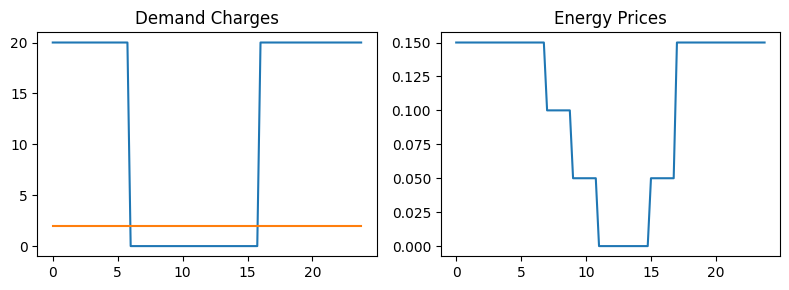

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.subplot(121)
for ct, item in enumerate(demand_charges):
    yval = np.zeros((96, )); yval[item[1]] = item[0]
    plt.plot(0.25*np.arange(0, 96), yval)
plt.title('Demand Charges')
plt.subplot(122)
all_ys = np.zeros((96, len(energy_charges)))
for ct, item in enumerate(energy_charges):
    yval = np.zeros((96, )); yval[item[1]] = item[0]
    all_ys[:, ct] = yval
plt.plot(0.25*np.arange(0, 96), np.max(all_ys, axis=1))#yval)
plt.title('Energy Prices')
plt.tight_layout()
plt.show()

### implement control

In [8]:
def new_controlled_load(self, demand_charges, energy_charges, verbose=False):
    """Implements the charging control, including TOU and demand charges."""
    
    schedule = cvx.Variable((96, self.num_sessions))
    
    obj = 0
    for ct, item in enumerate(demand_charges): # demand charges
        obj += item[0] * cvx.max(cvx.sum(schedule[item[1], :], axis=1)) 
    for ct, item in enumerate(energy_charges): # demand charges
        yval = np.zeros((96, )); yval[item[1]] = item[0]
        obj += cvx.matmul(cvx.sum(schedule, axis=1), yval.reshape((-1, 1)))
    
    constraints = [schedule >= 0]
    for i in range(self.num_sessions):
        constraints += [schedule[:, i] <= np.maximum(np.max(self.power[:, i]), self.charge_rate)]
        if self.departure_inds[i] >= self.arrival_inds[i]:
            if self.arrival_inds[i] > 0:
                constraints += [schedule[np.arange(0, int(self.arrival_inds[i])), i] <= 0]
            if self.departure_inds[i] < 96:
                constraints += [schedule[np.arange(int(self.departure_inds[i]), 96), i] <= 0]
        else:
            constraints += [schedule[np.arange(int(self.departure_inds[i]), int(self.arrival_inds[i])), i] <= 0]

    constraints += [0.25 * cvx.sum(schedule, axis=0) == self.energies]

    prob = cvx.Problem(cvx.Minimize(obj), constraints)
    result = prob.solve(solver="CLARABEL")
    if verbose:
        print('The objective result: ', result)
    if schedule.value is None:
        print('Optimization failed')
    else:
        return schedule.value, np.sum(schedule.value, axis=1)


In [9]:
num_runs = 100
num_cars = 5 # 250
t0 = time.time()
input_data = np.zeros((num_runs, 96))
output_data_control = np.zeros((num_runs, 96))
for i in range(num_runs):
    if np.mod(i, int(num_runs/100)) == 0:
        print('\r',f'{i/num_runs*100:.0f}% done',end=' ')
        if i > 0:
            print(f'(eta',str(dt.timedelta(seconds=(time.time()-t0)/i*(num_runs-i)))[:-7],end=')')
    uncontrolled_load, start_times, end_times = load_data(num_cars)
    load = LoadModel(num_sessions=num_cars) 
    load.input_data(uncontrolled_load, start_times, end_times)
    input_data[i, :] = load.uncontrolled_total_load

    # Run each of the controls and save the outputs
    power, total_load = new_controlled_load(load, demand_charges, energy_charges)
    output_data_control[i, :] = total_load
print("\rDone                      ")

 1% done (eta 0:00:20)

/usr/local/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 0.22.2.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Done                      


In [10]:
y = np.copy(output_data_control)#[:(i-1), :])
X = np.copy(input_data)#[:(i-1), :])

In [11]:
np.save('X_custom_rate.npy', X)
np.save('y_custom_rate.npy', y)
np.shape(output_data_control)

(100, 96)

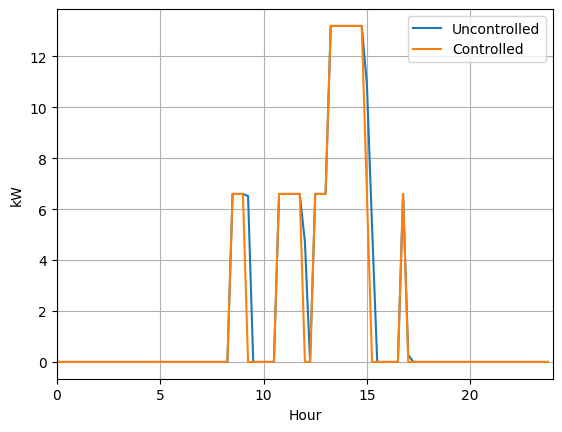

In [12]:
idx = 10
plt.figure()
plt.plot(0.25*np.arange(0, 96), X[idx, :])
plt.plot(0.25*np.arange(0, 96), y[idx, :])
plt.legend(labels=['Uncontrolled', 'Controlled'])
plt.ylabel('kW'); plt.xlabel('Hour'); plt.xlim([0, 24])
plt.grid()
plt.show()

# 2. fit model (or multiple models)

and report the results / error metric

In [13]:
def normalize_profiles(uncontrolled_profiles, controlled_profiles, return_norms=False):
    
    uncont_norm, norms_out = normalize(uncontrolled_profiles, norm='max', axis=1, return_norm=True)
    cont_norm = np.zeros(np.shape(controlled_profiles))
    for i in range(np.shape(controlled_profiles)[0]):
        cont_norm[i, :] = controlled_profiles[i, :] / norms_out[i]
        
    if return_norms:
        return uncont_norm, cont_norm, norms_out
    else:
        return uncont_norm, cont_norm

def max_absolute_error(y_true, y_pred):
    diff = np.abs(y_true - y_pred).max()
    return diff
score = metrics.make_scorer(max_absolute_error, greater_is_better=False)

def aggregate(uncontrolled_profiles, controlled_profiles, shuffle=False, k=10):
    
    if shuffle:
        length = np.shape(uncontrolled_profiles)[0]
        new_inds = np.random.choice(range(length), length, replace=False)
        uncontrolled_profiles = uncontrolled_profiles[new_inds, :]
        controlled_profiles = controlled_profiles[new_inds, :]

    new_uncontrolled_profiles = np.zeros((int(np.shape(uncontrolled_profiles)[0]/k), np.shape(uncontrolled_profiles)[1]))
    new_controlled_profiles = np.zeros((int(np.shape(uncontrolled_profiles)[0]/k), np.shape(uncontrolled_profiles)[1]))
    for i in range(int(np.shape(uncontrolled_profiles)[0]/k)):
        for j in range(k):
            new_uncontrolled_profiles[i, :] += uncontrolled_profiles[k*i + j, :]
            new_controlled_profiles[i, :] += controlled_profiles[k*i + j, :]
            
    return uncontrolled_profiles, controlled_profiles, new_uncontrolled_profiles, new_controlled_profiles

In [14]:
def agg_fit_test(uncontrolled_profiles, controlled_profiles, return_all=False, agg=False):
    
    if agg:
        uncontrolled_profiles, controlled_profiles, new_uncontrolled_profiles, new_controlled_profiles = aggregate(uncontrolled_profiles, 
                                                                                                                   controlled_profiles, shuffle=True, k=10)
    else:
        new_uncontrolled_profiles = np.copy(uncontrolled_profiles)
        new_controlled_profiles = np.copy(controlled_profiles)
    
    uncont_norm, cont_norm = normalize_profiles(new_uncontrolled_profiles, new_controlled_profiles)
    X_train, X_test, y_train, y_test = train_test_split(uncont_norm, cont_norm, test_size=0.2, random_state=42)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=1/8, random_state=42)

    param_grid = {'alpha':np.linspace(0, 2, 50)}
    clf_grid = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=5) 
    clf_grid.fit(X_train, y_train)
    new_clf = clf_grid.best_estimator_
#     new_clf = LinearRegression(fit_intercept=True)
    new_clf.fit(X_train, y_train)

    mean_error = metrics.mean_squared_error(y_dev, new_clf.predict(X_dev))
    max_error =  max_absolute_error(y_dev, new_clf.predict(X_dev))
    print('Mean squared error:', mean_error)
    print('Max abs error:', max_error)
    if return_all:
        return new_clf, X_train, X_dev, X_test, y_train, y_dev, y_test
    else:
        return new_clf

In [15]:
# control = 'PGEcev'
clf, X_train, X_dev, X_test, y_train, y_dev, y_test = agg_fit_test(X, y, return_all=True)

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Mean squared error: 0.004346259009713286
Max abs error: 0.36240939065304456


In [16]:
# new_clf = LinearRegression(fit_intercept=True)
# new_clf.fit(np.concatenate((X_train, X_dev), axis=0), np.concatenate((y_train, y_dev), axis=0))

# mean_error = metrics.mean_squared_error(y_test, new_clf.predict(X_test))
# max_error =  max_absolute_error(y_test, new_clf.predict(X_test))
# print('Mean squared error:', mean_error)
# print('Max abs error:', max_error)


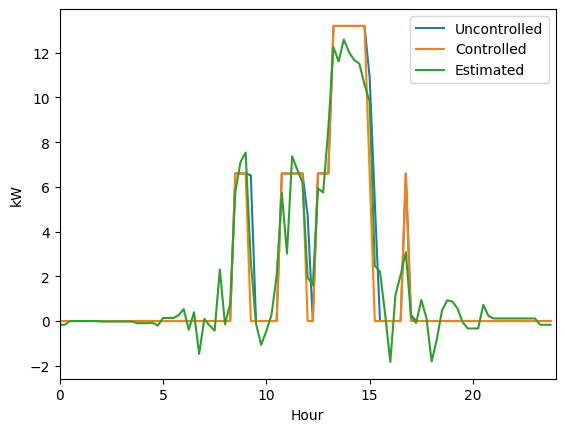

In [17]:
idx = 10

Xnorm, ynorm, norms = normalize_profiles(X, y, return_norms=True)
ypred_norm = clf.predict(Xnorm[idx, :].reshape(1, -1))
ypred = norms[idx] * ypred_norm
plt.figure()
plt.plot(0.25*np.arange(0, 96), X[idx, :])
plt.plot(0.25*np.arange(0, 96), y[idx, :])
plt.plot(0.25*np.arange(0, 96), ypred.ravel())
plt.legend(labels=['Uncontrolled', 'Controlled', 'Estimated'])
plt.ylabel('kW'); plt.xlabel('Hour'); plt.xlim([0, 24])
plt.show()

In [18]:
def save(clf, folder, name_str, bucket=None, bucket_folder=None):
    
    pickle.dump(clf, open(folder+name_str+'.p', "wb"))
    if bucket is not None:
        s3 = boto3.client('s3')
        s3.upload_file(folder+name_str+'.p', bucket, bucket_folder+name_str+'.p')

In [19]:
# save(clf, '', 'control_custom_rate',
#      bucket='script.control.tool', 
#      bucket_folder='Control_Objects/')

# 3. apply to scenario

In [20]:
from evloadmodel import EVLoadModel
from configurations_script import FinalReport

In [21]:
control_rule = 'custom_rate'

total_num_evs = 5e6
res_percent = 0.4
fast_percent = 0.05
publicl2_percent = 0.05
work_percent = 0.5
rent_percent = 0.1
l1_percent = 0.2
weekday = True
res_daily_use = 0.8
work_daily_use = 0.8
fast_daily_use = 0.33
publicl2_daily_use = 0.33
even_spread_geo_percent = 0.0
battery_dict = None

In [22]:
config = FinalReport(total_num_evs=total_num_evs, aggregation_level='state',
                    res_percent=res_percent, fast_percent=fast_percent, publicl2_percent=publicl2_percent, work_percent=work_percent, rent_percent=rent_percent, 
                    l1_percent=l1_percent, res_l2_smooth=False, week_day=weekday,
                    res_daily_use=res_daily_use, work_daily_use=work_daily_use, fast_daily_use=fast_daily_use, publicl2_daily_use=publicl2_daily_use,
                    mixed_batteries=battery_dict, time_steps=96)

config.control_folder_path = 'Control_Objects'
config.sample_fast=True

model = EVLoadModel(config)
model.calculate_basic_load(verbose=False)
model.apply_control(control_rule=control_rule, segment='Work')


/usr/local/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 0.22.2.post1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ClientError: An error occurred (AccessDenied) when calling the GetObject operation: Access Denied

In [ ]:
model.plot_labeled_load()

In [ ]:
model.plot_labeled_load(model.controlled_segmented_load)

In [ ]:
def plot_labeled_load(ax, plotting_data, set_ylim=None, work=False):

    x = (24 / np.shape(plotting_data)[0]) * np.arange(0, np.shape(plotting_data)[0])
    mark = np.zeros(np.shape(x))
    scaling = 1 / 1000
    unit = 'MW'
    for key in plotting_data.keys()[:-1]:
        if work and (key == 'Work'):
            ax.plot(0.25*np.arange(0, 96), scaling * (mark[np.arange(0, 1440, 15)] + plotting_data[key][np.arange(0, 1440, 15)]))
            ax.fill_between(0.25*np.arange(0, 96), scaling * mark[np.arange(0, 1440, 15)], scaling * (mark[np.arange(0, 1440, 15)] + plotting_data[key][np.arange(0, 1440, 15)]), alpha=0.5)
            mark += plotting_data[key]
        else:
            ax.plot(x, scaling * (mark + plotting_data[key]))
            ax.fill_between(x, scaling * mark, scaling * (mark + plotting_data[key]), alpha=0.5)
            mark += plotting_data[key]
    ax.plot(x, scaling * mark, 'k')
    ax.set_xlim([0, 24])
    if set_ylim is None:
        ax.set_ylim([0, 1.1 * np.max(scaling * mark)])
    else:
        ax.set_ylim([0, set_ylim])

    return ax

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(22,4.5))
fonts = 13.5

labels = ['Residential L1', 'Residential L2', 'MUD L2', 'Workplace L2 - uncontrolled', 'Public L2', 'Public DCFC']

ax[1] = plot_labeled_load(ax[1], pd.DataFrame(model.sampled_loads_dict), set_ylim=6000)
cont = pd.DataFrame(model.sampled_controlled_loads_dict)
cont['Total'] = cont.sum(axis=1)
ax[2] = plot_labeled_load(ax[2], cont, set_ylim=6000)

ax[0].plot(0.25*np.arange(0, 96), (1/1000)*model.load_segments['Work']['Load'], '--', color='C3')
ax[0].plot(0.25*np.arange(0, 96), (1/1000)*model.controlled_load_segments_dict['Work']['Load'], color='C3')
ax[0].set_xlim([0, 23.75]); ax[0].set_ylim([0, 1.1*np.max((1/1000)*model.load_segments['Work']['Load'])])
ax[0].legend(labels=['Workplace - uncontrolled', 'Workplace - est. controlled'], fontsize=fonts-1, loc='upper left')

for i in range(3):
    ax[i].set_xticks([0, 6, 12, 18]); ax[i].set_xticklabels([0, 6, 12, 18], fontsize=fonts)
    ax[i].set_xlabel('Time of day [h]', fontsize=fonts)
    if i == 0:
        ax[i].set_yticks([1000, 2000, 3000, 4000, 5000, 6000]); ax[i].set_yticklabels([1, 2, 3, 4, 5, 6], fontsize=fonts)
        ax[i].set_ylabel('Load [GW]', fontsize=fonts)
    else:
        ax[i].set_yticks([])
        
    if i == 1:
        ax[i].legend(loc='upper left', labels=labels, fontsize=fonts-1, ncol=2)
    if i == 2:
        ax[i].legend(loc='upper left', labels=['Residential L1', 'Residential L2', 'MUD L2', 'Workplace L2 - est. controlled', 'Public L2', 'Public DCFC'], fontsize=fonts-1, ncol=2)

plt.tight_layout()
plt.savefig('custom_plots.pdf', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure()
plt.plot(0.25*np.arange(0, 96), model.load_segments['Work']['Load'])
plt.plot(0.25*np.arange(0, 96), model.controlled_load_segments_dict['Work']['Load'])
plt.xlim([0, 24]); plt.xlabel('Hour'); plt.ylabel('kW');
plt.legend(labels=['Workplace - uncontrolled', 'Workplace control estimate'])
plt.show()